# Neural Network — Prédiction du rendement next-day d'un indice boursier

Réseau feedforward **from scratch** (NumPy) :
- **Input** : 5 neurones (rendements passés J-1 … J-5)
- **Hidden** : n_hidden neurones (activation **tanh**)
- **Output** : 1 neurone (activation **sigmoid** → probabilité que le return soit > 0)

Entraîné par **backpropagation** avec descente de gradient.

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. Chargement des données

In [ ]:
def load_index_data_stooq(symbol="spy.us", start="2022-01-01", end="2025-02-01"):
    """
    Télécharge des données daily depuis Stooq.
    Exemples symbol:
      spy.us  (ETF S&P500)
      qqq.us  (ETF Nasdaq)
      dia.us  (ETF Dow Jones)
      iwv.us  (ETF Russell 3000)
    """
    url = f"https://stooq.com/q/d/l/?s={symbol}&i=d"
    df = pd.read_csv(url)

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date")

    df = df[(df["Date"] >= start) & (df["Date"] < end)].copy()
    df = df[["Date", "Close"]].dropna().copy()
    df["Return"] = df["Close"].pct_change()
    df = df.dropna().reset_index(drop=True)

    print(f"{symbol} : {len(df)} jours ({df['Date'].min().date()} → {df['Date'].max().date()})")
    return df

In [50]:
def load_index_data_pipeline(db_path, market_ticker="^GSPC"):
    """
    Charge les rendements depuis la base SQLite du pipeline.
    """
    import sqlite3, pandas as pd

    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(
        "SELECT Date, Ticker, AdjClose, Return FROM returns "
        "WHERE Ticker = ? ORDER BY Date",
        conn, params=[market_ticker], parse_dates=["Date"])
    conn.close()
    df = df.dropna(subset=["Return"]).reset_index(drop=True)
    print(f"  Pipeline DB : {len(df)} jours pour {market_ticker}")
    return df.rename(columns={"AdjClose": "Close"})

## 2. Préparation des features (fenêtre glissante de 5 jours)

In [51]:
def build_features(returns, n_lags=5):
    """
    Crée X (n_samples, n_lags) et y (n_samples, 1) pour une tâche de régression.

    Chaque ligne i :
        X[i] = [return(t-1), return(t-2), ..., return(t-n_lags)]
        y[i] = return(t)  (valeur réelle)
    """
    ret = returns.values
    X, y = [], []

    for i in range(n_lags, len(ret)):
        window = ret[i - n_lags : i][::-1]
        X.append(window)
        y.append(ret[i])  # régression: cible continue

    X = np.array(X)
    y = np.array(y).reshape(-1, 1)

    print(f"  Features : X {X.shape}, y {y.shape}")
    print(f"  y stats : mean={y.mean():.6f}, std={y.std():.6f}, min={y.min():.6f}, max={y.max():.6f}")
    return X, y

## 3. Train / Test split (temporel)

In [52]:
def train_test_split_temporal(X, y, train_ratio=0.8):
    """
    Split temporel : les premières 80 % des données pour l'entraînement,
    les 20 % restantes pour le test.
    """
    n = int(len(X) * train_ratio)
    X_train, y_train = X[:n], y[:n]
    X_test, y_test   = X[n:], y[n:]

    print(f"  Train : {X_train.shape[0]} samples")
    print(f"  Test  : {X_test.shape[0]} samples")
    return X_train, y_train, X_test, y_test

## 4. Le réseau de neurones (from scratch)

### 4.1 Initialisation

In [53]:
def initialisation(n_input, n_hidden, n_output):
    """
    Initialise les poids et biais du réseau 2 couches.

    Architecture :
        Input  (n_input=5)  →  Hidden (n_hidden)  →  Output (n_output=1)
    """
    np.random.seed(42)
    W1 = np.random.randn(n_input, n_hidden) * 0.01     # (5, n_hidden)
    b1 = np.zeros((1, n_hidden))                        # (1, n_hidden)
    W2 = np.random.randn(n_hidden, n_output) * 0.01    # (n_hidden, 1)
    b2 = np.zeros((1, n_output))                        # (1, 1)

    parameters = {
        'W1': W1, 'b1': b1,
        'W2': W2, 'b2': b2
    }
    return parameters

### 4.2 Forward propagation

In [54]:
def forward_propagation(X, parameters):
    """
    Couche 1 : Z1 = X·W1 + b1,  A1 = tanh(Z1)
    Couche 2 : Z2 = A1·W2 + b2, A2 = Z2 (sortie linéaire pour régression)
    """
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']

    Z1 = X.dot(W1) + b1
    A1 = np.tanh(Z1)

    Z2 = A1.dot(W2) + b2
    A2 = Z2  # sortie linéaire

    activations = {
        'Z1': Z1, 'A1': A1,
        'Z2': Z2, 'A2': A2
    }
    return activations

### 4.3 Log loss

In [55]:
def mse_loss(y, y_hat):
    """
    Mean Squared Error.
    y et y_hat sont de shape (m, 1)
    """
    return np.mean((y_hat - y) ** 2)

### 4.4 Back propagation

In [56]:
def back_propagation(X, y, activations, parameters):
    """
    Gradients pour régression avec:
    A2 = Z2 (linéaire)
    Loss = MSE = mean((A2 - y)^2)
    """
    m = X.shape[0]
    A1, A2 = activations['A1'], activations['A2']
    W2 = parameters['W2']

    # dLoss/dA2 = 2*(A2 - y)/m
    dZ2 = (2.0 / m) * (A2 - y)                         # (m, 1)
    dW2 = A1.T.dot(dZ2)                                # (n_hidden, 1)
    db2 = np.sum(dZ2, axis=0, keepdims=True)           # (1, 1)

    # tanh' = 1 - A1^2
    dZ1 = dZ2.dot(W2.T) * (1.0 - A1 ** 2)              # (m, n_hidden)
    dW1 = X.T.dot(dZ1)                                  # (n_input, n_hidden)
    db1 = np.sum(dZ1, axis=0, keepdims=True)           # (1, n_hidden)

    gradients = {
        'dW1': dW1, 'db1': db1,
        'dW2': dW2, 'db2': db2
    }
    return gradients

### 4.5 Mise à jour des paramètres

In [57]:
def update(gradients, parameters, learning_rate):
    parameters['W1'] -= learning_rate * gradients['dW1']
    parameters['b1'] -= learning_rate * gradients['db1']
    parameters['W2'] -= learning_rate * gradients['dW2']
    parameters['b2'] -= learning_rate * gradients['db2']
    return parameters

### 4.6 Prédiction

In [58]:
def predict(X, parameters):
    activations = forward_propagation(X, parameters)
    return activations['A2']  # valeurs réelles

## 5. Boucle d'entraînement

In [59]:
from sklearn.metrics import mean_squared_error

def neural_network(X_train, y_train, X_test, y_test,
                   n_hidden=8, learning_rate=0.01, n_iter=2000, eval_every=10):
    """
    Entraîne le réseau (régression) et trace:
    1) MSE train et test
    2) Courbe predicted vs real returns sur le test
    """
    if not (5 <= n_hidden <= 10):
        raise ValueError("n_hidden doit être entre 5 et 10 selon le sujet.")

    n_input = X_train.shape[1]   # 5
    n_output = 1

    parameters = initialisation(n_input, n_hidden, n_output)

    train_mse, test_mse = [], []
    steps = []

    for i in range(n_iter):
        activations = forward_propagation(X_train, parameters)
        grads = back_propagation(X_train, y_train, activations, parameters)
        parameters = update(grads, parameters, learning_rate)

        if i % eval_every == 0:
            yhat_tr = activations['A2']
            mse_tr = mse_loss(y_train, yhat_tr)

            yhat_te = predict(X_test, parameters)
            mse_te = mse_loss(y_test, yhat_te)

            train_mse.append(mse_tr)
            test_mse.append(mse_te)
            steps.append(i)

    print(f"\n  Train MSE : {train_mse[-1]:.8f}")
    print(f"  Test  MSE : {test_mse[-1]:.8f}")

    # Plot MSE
    plt.figure(figsize=(8, 4))
    plt.plot(steps, train_mse, label="Train MSE")
    plt.plot(steps, test_mse, label="Test MSE")
    plt.xlabel("Itérations")
    plt.ylabel("MSE")
    plt.title("Évolution de la MSE")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot predicted vs real sur le test
    yhat_test = predict(X_test, parameters)

    plt.figure(figsize=(10, 4))
    plt.plot(y_test.flatten(), label="Real returns")
    plt.plot(yhat_test.flatten(), label="Predicted returns")
    plt.xlabel("Index (test)")
    plt.ylabel("Return")
    plt.title("Predicted vs Real returns (test)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return parameters

## 6. Exécution complète

### 6.1 Chargement des données

In [60]:
data = load_index_data_stooq(symbol="spy.us", start="2022-01-01", end="2025-02-01")
data.head()

spy.us : 772 jours (2022-01-04 → 2025-01-31)


,Date,Close,Return
0,2022-01-04,455.647,-0.000342
1,2022-01-05,446.900,-0.019197
2,2022-01-06,446.478,-0.000944
3,2022-01-07,444.710,-0.003960
4,2022-01-10,444.154,-0.001250


In [61]:
data.head(10)

,Date,Close,Return
0,2022-01-04,455.647,-0.000342
1,2022-01-05,446.900,-0.019197
2,2022-01-06,446.478,-0.000944
3,2022-01-07,444.710,-0.003960
4,2022-01-10,444.154,-0.001250
5,2022-01-11,448.201,0.009112
6,2022-01-12,449.417,0.002713
7,2022-01-13,443.224,-0.013780
8,2022-01-14,443.409,0.000417
9,2022-01-18,435.551,-0.017722


### 6.2 Construction des features

In [62]:
X, y = build_features(data["Return"], n_lags=5)

  Features : X (767, 5), y (767, 1)
  y stats : mean=0.000453, std=0.010977, min=-0.043484, max=0.054944


### 6.3 Split temporel + normalisation

In [63]:
X_train, y_train, X_test, y_test = train_test_split_temporal(X, y, train_ratio=0.8)

# Normalisation (mean=0, std=1 calculé sur le train uniquement)
mean_train = X_train.mean(axis=0)
std_train  = X_train.std(axis=0) + 1e-8
X_train = (X_train - mean_train) / std_train
X_test  = (X_test  - mean_train) / std_train   # même normalisation

print(f"\n  Architecture : 5 → 16 → 1  (tanh / sigmoid)")
print(f"  Données : {data['Date'].min().date()} → {data['Date'].max().date()}")

  Train : 613 samples
  Test  : 154 samples

  Architecture : 5 → 16 → 1  (tanh / sigmoid)
  Données : 2022-01-04 → 2025-01-31


### 6.4 Entraînement


  Train MSE : 0.00013180
  Test  MSE : 0.00007602


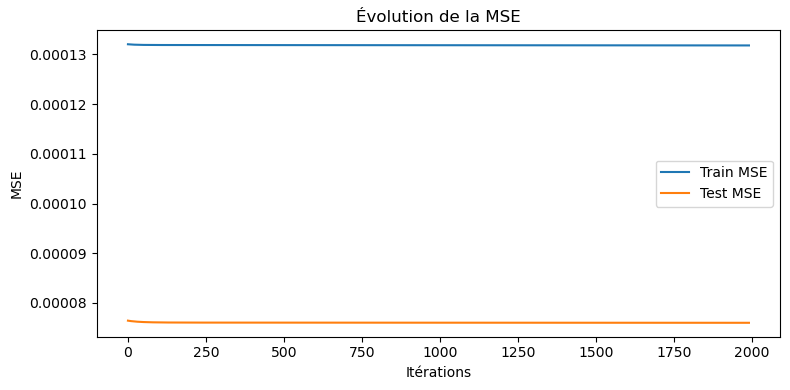

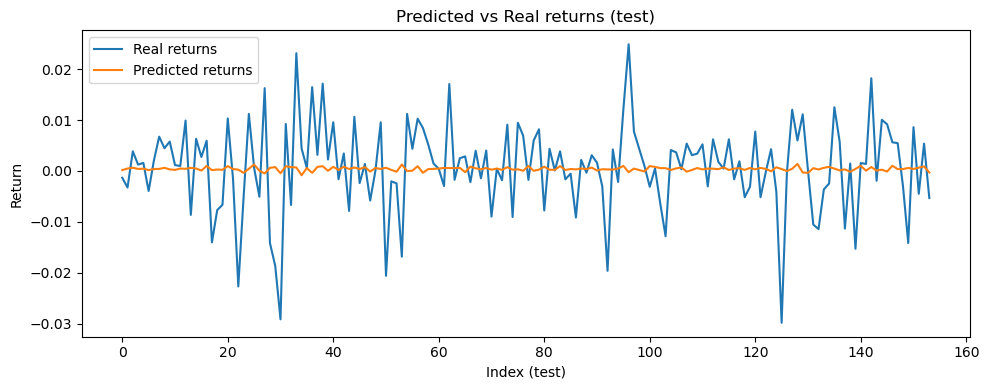

In [64]:
parameters = neural_network(
    X_train, y_train,
    X_test, y_test,
    n_hidden=8,
    learning_rate=0.01,
    n_iter=2000,
    eval_every=10
)

## 7. Analyse des résultats

In [65]:
def analyse_predictions_regression(X_test, y_test, parameters):
    """
    Analyse régression:
      - MSE, RMSE, MAE
      - Corrélation y vs y_hat
      - Plot predicted vs real
      - Scatter predicted vs real
    """
    import numpy as np
    import matplotlib.pyplot as plt

    y_hat = predict(X_test, parameters)

    mse = np.mean((y_hat - y_test) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_hat - y_test))

    corr = np.corrcoef(y_test.flatten(), y_hat.flatten())[0, 1]

    print("=" * 50)
    print("REGRESSION REPORT")
    print("=" * 50)
    print(f"MSE  : {mse:.8f}")
    print(f"RMSE : {rmse:.8f}")
    print(f"MAE  : {mae:.8f}")
    print(f"Corr : {corr:.4f}")

    plt.figure(figsize=(10, 4))
    plt.plot(y_test.flatten(), label="Real returns")
    plt.plot(y_hat.flatten(), label="Predicted returns")
    plt.xlabel("Index (test)")
    plt.ylabel("Return")
    plt.title("Predicted vs Real returns (test)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.scatter(y_test.flatten(), y_hat.flatten(), s=12)
    plt.xlabel("Real returns")
    plt.ylabel("Predicted returns")
    plt.title("Scatter: Predicted vs Real")
    plt.tight_layout()
    plt.show()

    return y_hat

REGRESSION REPORT
MSE  : 0.00007602
RMSE : 0.00871873
MAE  : 0.00639357
Corr : -0.0088


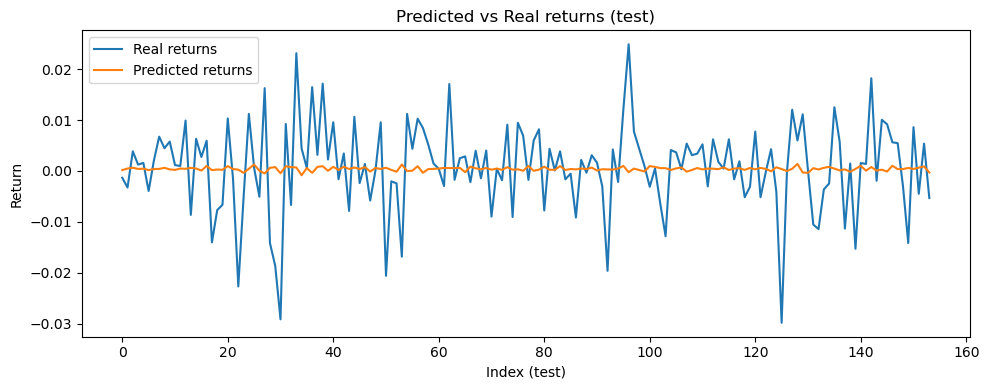

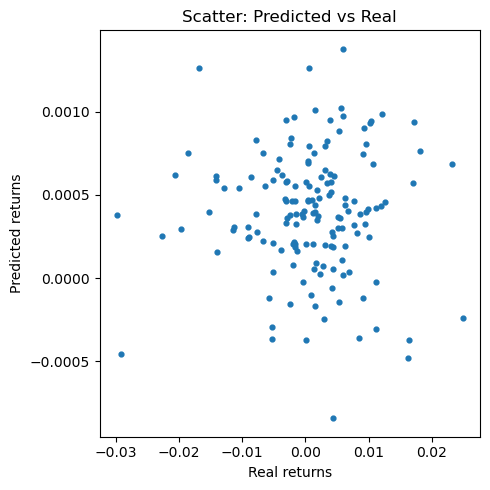

array([[ 1.65346531e-04],
       [ 4.78451622e-04],
       [ 6.26068154e-04],
       [ 3.94422209e-04],
       [ 4.42601892e-04],
       [ 1.68546812e-04],
       [ 3.74260013e-04],
       [ 4.02926712e-04],
       [ 6.14112221e-04],
       [ 3.03163770e-04],
       [ 2.07988415e-04],
       [ 4.72149495e-04],
       [ 4.13994245e-04],
       [ 6.08742078e-04],
       [ 4.79406027e-04],
       [ 7.55865850e-05],
       [ 9.75121982e-04],
       [ 1.55816001e-04],
       [ 2.79715001e-04],
       [ 2.21257142e-04],
       [ 9.45577844e-04],
       [ 3.86602558e-04],
       [ 2.52279202e-04],
       [-3.65506669e-04],
       [ 4.19119008e-04],
       [ 1.26513429e-03],
       [ 3.90158186e-05],
       [-4.80083078e-04],
       [ 6.11771035e-04],
       [ 7.55710007e-04],
       [-4.54330791e-04],
       [ 9.03827996e-04],
       [ 7.52475004e-04],
       [ 6.84299302e-04],
       [-8.43633218e-04],
       [ 5.54869680e-04],
       [-3.75422445e-04],
       [ 7.94306492e-04],
       [ 9.3

In [66]:
analyse_predictions_regression(X_test, y_test, parameters)

Linear Regression baseline
  Train MSE : 0.00013108
  Test  MSE : 0.00007656


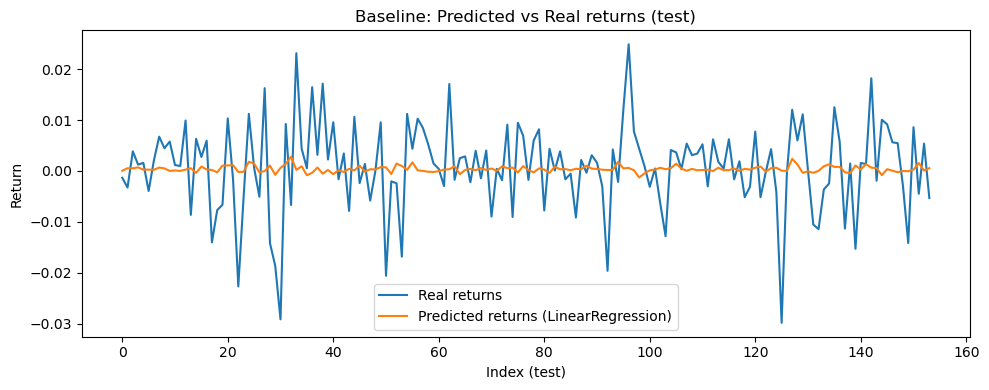

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg = LinearRegression()
linreg.fit(X_train, y_train)

yhat_tr_lr = linreg.predict(X_train)
yhat_te_lr = linreg.predict(X_test)

mse_tr_lr = mean_squared_error(y_train, yhat_tr_lr)
mse_te_lr = mean_squared_error(y_test, yhat_te_lr)

print(f"Linear Regression baseline")
print(f"  Train MSE : {mse_tr_lr:.8f}")
print(f"  Test  MSE : {mse_te_lr:.8f}")

plt.figure(figsize=(10, 4))
plt.plot(y_test.flatten(), label="Real returns")
plt.plot(yhat_te_lr.flatten(), label="Predicted returns (LinearRegression)")
plt.xlabel("Index (test)")
plt.ylabel("Return")
plt.title("Baseline: Predicted vs Real returns (test)")
plt.legend()
plt.tight_layout()
plt.show()